# Import Libraries

In [ ]:
## install pyportfolio (Min-Var Portfolio Allocation)
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 6.4 MB/s 
     |████████████████████████████████| 2.8 MB 27.9 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-6dtir3wm
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-6dtir3wm
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-zhbu5x1j/pyfolio_99feb84421a3443ba5348e687dd5c0de
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-zhbu5x1j/pyfolio_99feb84421a3443ba5348e687dd5c0de
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-zhbu5x1j/elegantrl_2f8fb3db843742508755e9f1b0b158e3
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-zhbu5x1j/elegantrl_2f8fb3db843742508755e9f1b0b158e3
     |████████████████████████████████| 73 kB 1.6 MB/s 
     |████████████████████████████████| 174 kB 21.0 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 kB/s 
     |████████████████████████████████| 1.8 MB 40.7 MB/s 
     |██████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
matplotlib.use('Agg')
%matplotlib inline
import datetime

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



# Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Functions

## Stock Trading Normal Environment

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

class StockTradingEnv(gym.Env):

    metadata = {"render.modes": ["human"]}

    def __init__(self, 
                 df, 
                 stock_dim, 
                 hmax, 
                 initial_amount, 
                 buy_cost_pct, 
                 sell_cost_pct, 
                 reward_scaling,
                 state_space,
                 action_space,
                 tech_indicator_list,
                 turbulence_threshold=None,
                 risk_indicator_col="turbulence",
                 make_plots=False,
                 print_verbosity=10,
                 day=0,
                 initial=True,
                 previous_state=[],
                 model_name="",
                 mode="",
                 iteration="",
                 ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_space,))
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initialize state
        self.state = self._initiate_state()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # sell only if current asset is > 0
                    sell_num_shares = min(abs(action), self.state[index + self.stock_dim + 1])
                    sell_amount = (self.state[index + 1]  * sell_num_shares  * (1 - self.sell_cost_pct))
                    # update balance
                    self.state[0] += sell_amount       
                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (self.state[index + 1] * sell_num_shares * self.sell_cost_pct)
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0
            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (self.state[index + 1] * sell_num_shares  * (1 - self.sell_cost_pct))
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (self.state[index + 1] * sell_num_shares * self.sell_cost_pct)
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()       
        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct))
                self.state[0] -= buy_amount
                self.state[index + self.stock_dim + 1] += buy_num_shares                
                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0
            return buy_num_shares
        
        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass
        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])) 
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (self.state[0]  + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))  - self.initial_amount)
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1)
            if df_total_value["daily_return"].std() != 0:
                sharpe = ((252 ** 0.5)  * df_total_value["daily_return"].mean() / df_total_value["daily_return"].std())
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")               
            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv("results/actions_{}_{}_{}.csv".format(self.mode, self.model_name, self.iteration))
                df_total_value.to_csv("results/account_value_{}_{}_{}.csv".format(self.mode, self.model_name, self.iteration), index = False,)
                df_rewards.to_csv("results/account_rewards_{}_{}_{}.csv".format(self.mode, self.model_name, self.iteration), index = False,)
                plt.plot(self.asset_memory, "r")
                plt.savefig("results/account_value_{}_{}_{}.png".format(self.mode, self.model_name, self.iteration), index = False,)
                plt.close()
            return self.state, self.reward, self.terminal, {}

        else:          
            actions = actions * self.hmax # actions initially is scaled between 0 to 1
            actions = actions.astype(int) # convert into integer because we can't buy fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]          
            for index in sell_index:
                actions[index] = self._sell_stock(index, actions[index]) * (-1)                
            for index in buy_index:
                actions[index] = self._buy_stock(index, actions[index])            
            self.actions_memory.append(actions)            
            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()
            end_total_asset = self.state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling  
        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))
            self.asset_memory = [previous_total_asset]        
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        self.episode += 1
        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For initial state
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = ([self.initial_amount]
                         + self.data.close.values.tolist()
                         + [0] * self.stock_dim
                         + sum([self.data[tech].values.tolist() 
                                for tech in self.tech_indicator_list], [],))
            else:
                # for single stock
                state = ([self.initial_amount]
                         + [self.data.close]
                         + [0] * self.stock_dim
                         + sum([[self.data[tech]] 
                                for tech in self.tech_indicator_list], []))
        else:
            # using previous state
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = ([self.previous_state[0]]
                         + self.data.close.values.tolist()
                         + self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                         + sum([self.data[tech].values.tolist() 
                                for tech in self.tech_indicator_list], [],))
            else:
                # for single stock
                state = ([self.previous_state[0]]
                         + [self.data.close]
                         + self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                         + sum([[self.data[tech]] 
                                for tech in self.tech_indicator_list], []))
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = ([self.state[0]]
                     + self.data.close.values.tolist()
                     + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                     + sum([self.data[tech].values.tolist() 
                            for tech in self.tech_indicator_list], [],))
        else:
            # for single stock
            state = ([self.state[0]]
                     + [self.data.close]
                     + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                     + sum([[self.data[tech]] 
                            for tech in self.tech_indicator_list], []))
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        df_account_value = pd.DataFrame({"date": date_list, "account_value": asset_list})
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]            
            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

## Stable Baselines 3 DRL Models & Agents

In [ ]:
import time

from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import (NormalActionNoise, OrnsteinUhlenbeckActionNoise,)
from stable_baselines3.common.vec_env import DummyVecEnv

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {"normal": NormalActionNoise, "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,}

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard
    """

    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

class DRLAgent:
    """
    Provides implementations for DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(self, 
                  model_name, 
                  policy="MlpPolicy", 
                  policy_kwargs=None, 
                  model_kwargs=None, 
                  verbose=1, 
                  seed=None, 
                  tensorboard_log=None,
                 ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]
        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(model_kwargs)
        model = MODELS[model_name](policy=policy,
                                   env=self.env,
                                   tensorboard_log=tensorboard_log,
                                   verbose=verbose,
                                   policy_kwargs=policy_kwargs,
                                   seed=seed,
                                   **model_kwargs,)
        return model

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps, 
                            tb_log_name=tb_log_name, 
                            callback=TensorboardCallback(),)
        return model

    @staticmethod
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        """
        Make a prediction
        """
        account_memory = []
        actions_memory = []
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")
        # test on the testing env
        state = environment.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(environment.initial_total_asset)
        done = False
        while not done:
            action = model.predict(state)[0]
            state, reward, done, _ = environment.step(action)
            total_asset = (environment.amount + (environment.price_ary[environment.day] * environment.stocks).sum())
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)
        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets

class DRLEnsembleAgent:
    @staticmethod
    def get_model(model_name, 
                  env, 
                  policy="MlpPolicy", 
                  policy_kwargs=None, 
                  model_kwargs=None, 
                  seed=None,
                  verbose=1,
                 ):

        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        if model_kwargs is None:
            temp_model_kwargs = MODEL_KWARGS[model_name]
        else:
            temp_model_kwargs = model_kwargs.copy()
        if "action_noise" in temp_model_kwargs:
            n_actions = env.action_space.shape[-1]
            temp_model_kwargs["action_noise"] = NOISE[temp_model_kwargs["action_noise"]](mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(temp_model_kwargs)
        model = MODELS[model_name](policy=policy,
                                   env=env,
                                   tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
                                   verbose=verbose,
                                   policy_kwargs=policy_kwargs,
                                   seed=seed,
                                   **temp_model_kwargs,)
        return model

    @staticmethod
    def train_model(model, model_name, tb_log_name, iter_num, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps,
                            tb_log_name=tb_log_name,
                            callback=TensorboardCallback(),)
        model.save(f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{total_timesteps//1000}k_{iter_num}")
        return model

    @staticmethod
    def get_validation_sharpe(iteration, model_name):
        """
        Calculate Sharpe ratio based on validation results
        """
        df_total_value = pd.read_csv("results/account_value_validation_{}_{}.csv".format(model_name, iteration))
        sharpe = ((4 ** 0.5) * df_total_value["daily_return"].mean() / df_total_value["daily_return"].std())
        return sharpe

    def __init__(self,
                 df,
                 train_period,
                 val_test_period,
                 rebalance_window,
                 validation_window,
                 stock_dim,
                 hmax,
                 initial_amount,
                 buy_cost_pct,
                 sell_cost_pct,
                 reward_scaling,
                 state_space,
                 action_space,
                 tech_indicator_list,
                 print_verbosity,
                ):
        self.df = df
        self.train_period = train_period
        self.val_test_period = val_test_period
        self.unique_trade_date = df[(df.date > val_test_period[0]) & (df.date <= val_test_period[1])].date.unique()
        self.rebalance_window = rebalance_window
        self.validation_window = validation_window
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.print_verbosity = print_verbosity

    def DRL_validation(self, model, test_data, test_env, test_obs):
        """
        Validation process
        """
        for i in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)

    def DRL_prediction(self, 
                       model, 
                       name, 
                       last_state, 
                       iter_num, 
                       turbulence_threshold, 
                       initial
                      ):
        """
        Make a prediction based on trained model
        """
        ## trading env
        trade_data = data_split(self.df,
                                start=self.unique_trade_date[iter_num - self.rebalance_window],
                                end=self.unique_trade_date[iter_num],)
        trade_env = DummyVecEnv([lambda: StockTradingEnv(trade_data,
                                                         self.stock_dim,
                                                         self.hmax,
                                                         self.initial_amount,
                                                         self.buy_cost_pct,
                                                         self.sell_cost_pct,
                                                         self.reward_scaling,
                                                         self.state_space,
                                                         self.action_space,
                                                         self.tech_indicator_list,
                                                         turbulence_threshold=turbulence_threshold,
                                                         initial=initial,
                                                         previous_state=last_state,
                                                         model_name=name,
                                                         mode="trade",
                                                         iteration=iter_num,
                                                         print_verbosity=self.print_verbosity,)])      
        trade_obs = trade_env.reset()
        for i in range(len(trade_data.index.unique())):
            action, _states = model.predict(trade_obs)
            trade_obs, rewards, dones, info = trade_env.step(action)
            if i == (len(trade_data.index.unique()) - 2):
                # print(env_test.render())
                last_state = trade_env.render()
        df_last_state = pd.DataFrame({"last_state": last_state})
        df_last_state.to_csv("results/last_state_{}_{}.csv".format(name, i), index = False)
        return last_state

    def run_ensemble_strategy(self, 
                              A2C_model_kwargs, 
                              PPO_model_kwargs, 
                              DDPG_model_kwargs,
                              SAC_model_kwargs,
                              TD3_model_kwargs, 
                              timesteps_dict
                             ):
        """
        Ensemble Strategy that combines PPO, A2C, DDPG, SAC and TD3
        """
        print("============Start Ensemble Strategy============")
        # for ensemble model, it's necessary to feed the last state  
        # of the previous model to the current model as the initial state
        last_state_ensemble = []
        ppo_sharpe_list = []
        ddpg_sharpe_list = []
        a2c_sharpe_list = []
        sac_sharpe_list = []
        td3_sharpe_list = []
        model_use = []
        validation_start_date_list = []
        validation_end_date_list = []
        iteration_list = []
        insample_turbulence = self.df[(self.df.date < self.train_period[1]) & (self.df.date >= self.train_period[0])]
        insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 0.90)
        start = time.time()
        for i in range(self.rebalance_window + self.validation_window,
                       len(self.unique_trade_date),
                       self.rebalance_window,
                      ):
            validation_start_date = self.unique_trade_date[i - self.rebalance_window - self.validation_window]
            validation_end_date = self.unique_trade_date[i - self.rebalance_window]
            validation_start_date_list.append(validation_start_date)
            validation_end_date_list.append(validation_end_date)
            iteration_list.append(i)
            print("============================================")
            ## initial state is empty
            if i - self.rebalance_window - self.validation_window == 0:
                # inital state
                initial = True
            else:
                # previous state
                initial = False
            # tuning trubulence index based on historical data
            # turbulence lookback window is one quarter (63 days)
            end_date_index = self.df.index[self.df["date"] == self.unique_trade_date[i - self.rebalance_window - self.validation_window]].to_list()[-1]
            start_date_index = end_date_index - 63 + 1
            historical_turbulence = self.df.iloc[start_date_index : (end_date_index + 1), :]
            historical_turbulence = historical_turbulence.drop_duplicates(subset=["date"])   
            historical_turbulence_mean = np.mean(historical_turbulence.turbulence.values)           
            if historical_turbulence_mean > insample_turbulence_threshold:
                # if the mean of the historical data is greater than the 90% quantile of insample turbulence data 
                # then we assume that the current market is volatile,
                # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
                # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
                turbulence_threshold = insample_turbulence_threshold
            else:
                # if the mean of the historical data is less than the 90% quantile of insample turbulence data
                # then we tune up the turbulence_threshold, meaning we lower the risk
                turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 1)            
            turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 0.99)
            print("turbulence_threshold: ", turbulence_threshold)

            ############## Environment Setup Starts ##############
            train = data_split(self.df,
                               start=self.train_period[0],
                               end=self.unique_trade_date[i - self.rebalance_window - self.validation_window],)
            self.train_env = DummyVecEnv([lambda: StockTradingEnv(train,
                                                                  self.stock_dim,
                                                                  self.hmax,
                                                                  self.initial_amount,
                                                                  self.buy_cost_pct,
                                                                  self.sell_cost_pct,
                                                                  self.reward_scaling,
                                                                  self.state_space,
                                                                  self.action_space,
                                                                  self.tech_indicator_list,
                                                                  print_verbosity=self.print_verbosity,)])
            
            validation = data_split(self.df,
                                    start=self.unique_trade_date[i - self.rebalance_window - self.validation_window],
                                    end=self.unique_trade_date[i - self.rebalance_window],)
            ############## Environment Setup Ends ##############

            ############## Training & Validation Starts ##############
            print("======Model Training From: ", self.train_period[0], "to ", self.unique_trade_date[i - self.rebalance_window - self.validation_window],)
            
            print("========A2C Training========")
            model_a2c = self.get_model("a2c", 
                                       self.train_env, 
                                       policy="MlpPolicy", 
                                       model_kwargs=A2C_model_kwargs)
            model_a2c = self.train_model(model_a2c,
                                         "a2c",
                                         tb_log_name = "a2c_{}".format(i),
                                         iter_num = i,
                                         total_timesteps = timesteps_dict["a2c"],) 
            print("======A2C Validation From: ", validation_start_date, "to ", validation_end_date,)
            val_env_a2c = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                               self.stock_dim,
                                                               self.hmax,
                                                               self.initial_amount,
                                                               self.buy_cost_pct,
                                                               self.sell_cost_pct,
                                                               self.reward_scaling,
                                                               self.state_space,
                                                               self.action_space,
                                                               self.tech_indicator_list,
                                                               turbulence_threshold=turbulence_threshold,
                                                               iteration=i,
                                                               model_name="A2C",
                                                               mode="validation",
                                                               print_verbosity=self.print_verbosity,)])
            val_obs_a2c = val_env_a2c.reset()
            self.DRL_validation(model=model_a2c,
                                test_data=validation,
                                test_env=val_env_a2c,
                                test_obs=val_obs_a2c,)
            sharpe_a2c = self.get_validation_sharpe(i, model_name = "A2C")
            print("A2C Sharpe Ratio: ", sharpe_a2c)

            print("========PPO Training========")
            model_ppo = self.get_model("ppo", 
                                       self.train_env, 
                                       policy = "MlpPolicy", 
                                       model_kwargs = PPO_model_kwargs)
            model_ppo = self.train_model(model_ppo,
                                         "ppo",
                                         tb_log_name = "ppo_{}".format(i),
                                         iter_num = i,
                                         total_timesteps = timesteps_dict["ppo"],)  
            print("======PPO Validation From: ", validation_start_date, "to ", validation_end_date,)
            val_env_ppo = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                               self.stock_dim,
                                                               self.hmax,
                                                               self.initial_amount,
                                                               self.buy_cost_pct,
                                                               self.sell_cost_pct,
                                                               self.reward_scaling,
                                                               self.state_space,
                                                               self.action_space,
                                                               self.tech_indicator_list,
                                                               turbulence_threshold = turbulence_threshold,
                                                               iteration = i,
                                                               model_name = "PPO",
                                                               mode = "validation",
                                                               print_verbosity = self.print_verbosity,)])
            val_obs_ppo = val_env_ppo.reset()
            self.DRL_validation(model = model_ppo,
                                test_data = validation,
                                test_env = val_env_ppo,
                                test_obs = val_obs_ppo,)
            sharpe_ppo = self.get_validation_sharpe(i, model_name = "PPO")
            print("PPO Sharpe Ratio: ", sharpe_ppo)

            print("========DDPG Training========")
            model_ddpg = self.get_model("ddpg",
                                        self.train_env,
                                        policy = "MlpPolicy",
                                        model_kwargs = DDPG_model_kwargs,)
            model_ddpg = self.train_model(model_ddpg,
                                          "ddpg",
                                          tb_log_name="ddpg_{}".format(i),
                                          iter_num = i,
                                          total_timesteps = timesteps_dict["ddpg"],)  # 50_000
            print("======DDPG Validation From: ", validation_start_date, "to ", validation_end_date,)
            val_env_ddpg = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                turbulence_threshold = turbulence_threshold,
                                                                iteration = i,
                                                                model_name = "DDPG",
                                                                mode = "validation",
                                                                print_verbosity = self.print_verbosity,)])
            val_obs_ddpg = val_env_ddpg.reset()
            self.DRL_validation(model = model_ddpg,
                                test_data = validation,
                                test_env = val_env_ddpg,
                                test_obs = val_obs_ddpg,)
            sharpe_ddpg = self.get_validation_sharpe(i, model_name = "DDPG")
            print("DDPG Sharpe Ratio: ", sharpe_ddpg)

            print("========SAC Training========")
            model_sac = self.get_model("sac",
                                       self.train_env,
                                       policy="MlpPolicy",
                                       model_kwargs=SAC_model_kwargs,
                                      )
            model_sac = self.train_model(model_sac,
                                         "sac",
                                         tb_log_name="sac_{}".format(i),
                                         iter_num=i,
                                         total_timesteps=timesteps_dict["sac"],) 
            print("======SAC Validation From: ", validation_start_date, "to ", validation_end_date,)
            val_env_sac = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                               self.stock_dim,
                                                               self.hmax,
                                                               self.initial_amount,
                                                               self.buy_cost_pct,
                                                               self.sell_cost_pct,
                                                               self.reward_scaling,
                                                               self.state_space,
                                                               self.action_space,
                                                               self.tech_indicator_list,
                                                               turbulence_threshold=turbulence_threshold,
                                                               iteration=i,
                                                               model_name="SAC",
                                                               mode="validation",
                                                               print_verbosity = self.print_verbosity,)])
            val_obs_sac = val_env_sac.reset()
            self.DRL_validation(model=model_sac,
                                test_data=validation,
                                test_env=val_env_sac,
                                test_obs=val_obs_sac,)
            sharpe_sac = self.get_validation_sharpe(i, model_name = "SAC")
            print("SAC Sharpe Ratio: ", sharpe_sac)

            print("========TD3 Training========")
            model_td3 = self.get_model("td3",
                                       self.train_env,
                                       policy = "MlpPolicy",
                                       model_kwargs = TD3_model_kwargs,)
            model_td3 = self.train_model(model_td3,
                                         "td3",
                                         tb_log_name="td3_{}".format(i),
                                         iter_num = i,
                                         total_timesteps = timesteps_dict["td3"],) 
            print("======TD3 Validation From: ", validation_start_date, "to ", validation_end_date,)
            val_env_td3 = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                               self.stock_dim,
                                                               self.hmax,
                                                               self.initial_amount,
                                                               self.buy_cost_pct,
                                                               self.sell_cost_pct,
                                                               self.reward_scaling,
                                                               self.state_space,
                                                               self.action_space,
                                                               self.tech_indicator_list,
                                                               turbulence_threshold = turbulence_threshold,
                                                               iteration = i,
                                                               model_name = "TD3",
                                                               mode = "validation",
                                                               print_verbosity = self.print_verbosity,)])
            val_obs_td3 = val_env_td3.reset()
            self.DRL_validation(model = model_td3,
                                test_data = validation,
                                test_env = val_env_td3,
                                test_obs = val_obs_td3,)
            sharpe_td3 = self.get_validation_sharpe(i, model_name = "TD3")
            print("TD3 Sharpe Ratio: ", sharpe_td3)

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)
            sac_sharpe_list.append(sharpe_sac)
            td3_sharpe_list.append(sharpe_td3)

            print("======Best Model Retraining From: ", self.train_period[0], "to ", self.unique_trade_date[i - self.rebalance_window],)
            
            # model selection based on Sharpe ratio
            if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg) & (sharpe_ppo >= sharpe_sac) & (sharpe_ppo >= sharpe_td3):
                model_use.append("PPO")
                model_ensemble = model_ppo
            elif (sharpe_a2c >= sharpe_ppo) & (sharpe_a2c >= sharpe_ddpg) & (sharpe_a2c >= sharpe_sac) & (sharpe_a2c >= sharpe_td3):
                model_use.append("A2C")
                model_ensemble = model_a2c
            elif (sharpe_sac >= sharpe_a2c) & (sharpe_sac >= sharpe_ppo) & (sharpe_sac >= sharpe_ddpg) * (sharpe_sac >= sharpe_td3):
                model_use.append("SAC")
                model_ensemble = model_sac         
            elif (sharpe_td3 >= sharpe_a2c) & (sharpe_td3 >= sharpe_ppo) & (sharpe_td3 >= sharpe_ddpg) & (sharpe_td3 >= sharpe_sac):
                model_use.append("TD3")
                model_ensemble = model_td3
            else:
                model_use.append("DDPG")
                model_ensemble = model_ddpg

            ############## Training & Validation Ends ##############

            ############## Trading Starts ##############
            print("======Trading From: ", self.unique_trade_date[i - self.rebalance_window], "to ", self.unique_trade_date[i],)
            last_state_ensemble = self.DRL_prediction(model = model_ensemble,
                                                      name = "ensemble",
                                                      last_state = last_state_ensemble,
                                                      iter_num = i,
                                                      turbulence_threshold = turbulence_threshold,
                                                      initial = initial,)
            ############## Trading Ends ##############
            
        end = time.time()
        print("Ensemble Strategy Took: ", (end - start) / 60, " minutes")
        df_summary = pd.DataFrame([iteration_list,
                                   validation_start_date_list,
                                   validation_end_date_list,
                                   model_use,
                                   a2c_sharpe_list,
                                   ppo_sharpe_list,
                                   ddpg_sharpe_list,
                                   sac_sharpe_list,
                                   td3_sharpe_list]).T
        df_summary.columns = ["Iter",
                              "Val Start",
                              "Val End",
                              "Model Used",
                              "A2C Sharpe",
                              "PPO Sharpe",
                              "DDPG Sharpe",
                              "SAC Sharpe",
                              "TD3 Sharpe"]
        return df_summary

# Download Data

In [ ]:
# DOW_30_TICKER
# NAS_100_TICKER
# SP_500_TICKER

In [ ]:
# index constituents
print(config.NAS_100_TICKER)

['AMGN', 'AAPL', 'AMAT', 'INTC', 'PCAR', 'PAYX', 'MSFT', 'ADBE', 'CSCO', 'XLNX', 'QCOM', 'COST', 'SBUX', 'FISV', 'CTXS', 'INTU', 'AMZN', 'EBAY', 'BIIB', 'CHKP', 'GILD', 'NLOK', 'CMCSA', 'FAST', 'ADSK', 'CTSH', 'NVDA', 'GOOGL', 'ISRG', 'VRTX', 'HSIC', 'BIDU', 'ATVI', 'ADP', 'ROST', 'ORLY', 'CERN', 'BKNG', 'MYL', 'MU', 'DLTR', 'ALXN', 'SIRI', 'MNST', 'AVGO', 'TXN', 'MDLZ', 'FB', 'ADI', 'WDC', 'REGN', 'LBTYK', 'VRSK', 'NFLX', 'TSLA', 'CHTR', 'MAR', 'ILMN', 'LRCX', 'EA', 'AAL', 'WBA', 'KHC', 'BMRN', 'JD', 'SWKS', 'INCY', 'PYPL', 'CDW', 'FOXA', 'MXIM', 'TMUS', 'EXPE', 'TCOM', 'ULTA', 'CSX', 'NTES', 'MCHP', 'CTAS', 'KLAC', 'HAS', 'JBHT', 'IDXX', 'WYNN', 'MELI', 'ALGN', 'CDNS', 'WDAY', 'SNPS', 'ASML', 'TTWO', 'PEP', 'NXPI', 'XEL', 'AMD', 'NTAP', 'VRSN', 'LULU', 'WLTW', 'UAL']


In [ ]:
df = YahooDownloader(start_date = "2000-01-01",
                     end_date = "2021-11-01",
                     ticker_list = config.NAS_100_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.856887,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,46.750000,46.937500,44.000000,29.667690,3655600.0,ADI,0
3,2000-01-03,42.428928,42.775894,41.189766,25.976391,2698899.0,ADP,0
4,2000-01-03,8.500000,8.656250,8.031250,8.052905,2845600.0,ADSK,0
...,...,...,...,...,...,...,...,...
474526,2021-10-29,49.919998,53.500000,49.500000,52.290001,18239400.0,WDC,4
474527,2021-10-29,246.990005,248.809998,239.690002,242.279999,2288400.0,WLTW,4
474528,2021-10-29,90.650002,91.449997,88.769997,89.800003,2957700.0,WYNN,4
474529,2021-10-29,65.519997,65.599998,64.089996,64.589996,4082900.0,XEL,4


# Preprocess Data

In [ ]:
# technical indicators list
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
# add technical indicators, vix and turbulence
fe = FeatureEngineer(use_technical_indicator = True,
                     tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                     use_vix = True,
                     use_turbulence = True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (5492, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.856887,535796800.0,AAPL,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,0.856887,0.856887,24.209999,0.000000
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,16.274673,16.274673,24.209999,0.000000
2,2000-01-03,46.750000,46.937500,44.000000,29.667690,3655600.0,ADI,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,29.667690,29.667690,24.209999,0.000000
3,2000-01-03,42.428928,42.775894,41.189766,25.976391,2698899.0,ADP,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,25.976391,25.976391,24.209999,0.000000
4,2000-01-03,8.500000,8.656250,8.031250,8.052905,2845600.0,ADSK,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,8.052905,8.052905,24.209999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362467,2021-10-28,181.190002,183.830002,181.009995,182.000000,1356700.0,VRTX,3,-0.769586,187.090115,176.283889,43.879855,-12.260463,25.104128,182.503335,189.037501,16.530001,198.477037
362468,2021-10-28,47.080002,47.349998,46.660000,46.649181,4843900.0,WBA,3,-0.111101,49.586806,45.415096,46.118052,-103.269560,0.268701,47.628716,48.092658,16.530001,198.477037
362469,2021-10-28,55.860001,57.340000,55.840000,57.279999,4112600.0,WDC,3,-0.464545,58.114225,54.402775,46.653571,20.003535,1.780329,56.590333,59.233333,16.530001,198.477037
362470,2021-10-28,63.080002,64.589996,62.330002,64.330002,3178400.0,XEL,3,-0.094605,66.394726,62.163276,46.979416,-7.585519,33.946424,63.818667,66.046343,16.530001,198.477037


In [ ]:
# data wrangling
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed["date"].min(),
                 processed["date"].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

processed_full = pd.DataFrame(combination,
                              columns = ["date", "tic"]).merge(processed,
                                                               on = ["date", "tic"],
                                                               how = "left")
processed_full = processed_full[processed_full["date"].isin(processed["date"])]
processed_full = processed_full.sort_values(["date", "tic"])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.856887,535796800.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,0.856887,0.856887,24.209999,0.000000
1,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274673,7384400.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,16.274673,16.274673,24.209999,0.000000
2,2000-01-03,ADI,46.750000,46.937500,44.000000,29.667690,3655600.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,29.667690,29.667690,24.209999,0.000000
3,2000-01-03,ADP,42.428928,42.775894,41.189766,25.976391,2698899.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,25.976391,25.976391,24.209999,0.000000
4,2000-01-03,ADSK,8.500000,8.656250,8.031250,8.052905,2845600.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,8.052905,8.052905,24.209999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526015,2021-10-28,VRTX,181.190002,183.830002,181.009995,182.000000,1356700.0,3.0,-0.769586,187.090115,176.283889,43.879855,-12.260463,25.104128,182.503335,189.037501,16.530001,198.477037
526016,2021-10-28,WBA,47.080002,47.349998,46.660000,46.649181,4843900.0,3.0,-0.111101,49.586806,45.415096,46.118052,-103.269560,0.268701,47.628716,48.092658,16.530001,198.477037
526017,2021-10-28,WDC,55.860001,57.340000,55.840000,57.279999,4112600.0,3.0,-0.464545,58.114225,54.402775,46.653571,20.003535,1.780329,56.590333,59.233333,16.530001,198.477037
526018,2021-10-28,XEL,63.080002,64.589996,62.330002,64.330002,3178400.0,3.0,-0.094605,66.394726,62.163276,46.979416,-7.585519,33.946424,63.818667,66.046343,16.530001,198.477037


In [ ]:
# set turbulence threshold
data_risk_indicator = processed_full[(processed_full.date < "2020-01-01") & (processed_full.date >= "2000-01-01")]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset = ["date"])

# Ensemble Strategy

## Design Environment

In [ ]:
train = data_split(processed_full, "2000-01-01", "2020-01-01")
trade = data_split(processed_full, "2020-01-01", "2021-10-01")
print(len(train))
print(len(trade))

332046
29106


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 66, State Space: 661


In [ ]:
# rebalance_window is the number of days to retrain the model
rebalance_window = 63

# validation_window is the number of days to do validation and trading
validation_window = 63

train_start = "2000-01-01"
train_end = "2019-10-02"
val_test_start = "2019-10-02"
val_test_end = "2021-11-01"

In [ ]:
env_kwargs = {"hmax": 100, 
              "initial_amount": 1000000, 
              "buy_cost_pct": 0.001, 
              "sell_cost_pct": 0.001, 
              "state_space": state_space, 
              "stock_dim": stock_dimension, 
              "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
              "action_space": stock_dimension, 
              "reward_scaling": 1e-4,
              "print_verbosity":500}

## Implement DRL Algorithms

In [ ]:
ensemble_agent = DRLEnsembleAgent(df = processed,
                                  train_period = (train_start, train_end),
                                  val_test_period = (val_test_start, val_test_end),
                                  rebalance_window = rebalance_window,
                                  validation_window = validation_window,
                                  **env_kwargs)

A2C_model_kwargs = {'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005}

PPO_model_kwargs = {"ent_coef": 0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64}

DDPG_model_kwargs = {"buffer_size": 100_000,
                     "learning_rate": 0.000005,
                     "batch_size": 64}

SAC_model_kwargs = {"batch_size": 64, 
                    "buffer_size": 1000000,
                    "learning_rate": 0.0001,
                    "learning_starts": 100,
                    "ent_coef": "auto_0.1"}

TD3_model_kwargs = {"batch_size": 64, 
                    "buffer_size": 1000000, 
                    "learning_rate": 0.001}

timesteps_dict = {'a2c' : 25000, 
                  'ppo' : 25000, 
                  'ddpg' : 25000, 
                  'sac': 25000,
                  'td3': 25000}

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                  PPO_model_kwargs,
                                                  DDPG_model_kwargs,
                                                  SAC_model_kwargs,
                                                  TD3_model_kwargs,
                                                  timesteps_dict)

| train/                |            |
|    entropy_loss       | -90.9      |
|    explained_variance | -0.0542    |
|    learning_rate      | 0.0005     |
|    n_updates          | 699        |
|    policy_loss        | 939        |
|    reward             | 0.02222342 |
|    std                | 1          |
|    value_loss         | 126        |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 20        |
|    iterations         | 800       |
|    time_elapsed       | 192       |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -90.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 799       |
|    policy_loss        | 925       |
|    reward             | 1.5926155 |
|    std                | 1         |
|    value_loss         | 188       |
-------------------------------------
--

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 12         |
|    time_elapsed    | 1723       |
|    total_timesteps | 21136      |
| train/             |            |
|    actor_loss      | 11.4       |
|    critic_loss     | 15.5       |
|    learning_rate   | 5e-06      |
|    n_updates       | 15852      |
|    reward          | 0.27769744 |
-----------------------------------
======DDPG Validation From:  2021-01-04 to  2021-04-06
DDPG Sharpe Ratio:  0.17773416498475764
========SAC Training========
{'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac/sac_441_1
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 10        |
|    time_elapsed    | 2089      |
|    total_timesteps | 21136     |
| train/             |  

-----------------------------------------
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 8           |
|    time_elapsed         | 866         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.08476561  |
|    clip_fraction        | 0.504       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.9       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.14       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0394     |
|    reward               | -0.59803426 |
|    std                  | 1.02        |
|    value_loss           | 2.2         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 18         |
|    iterations           | 9        

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2019-10-03,2020-01-03,SAC,0.332707,0.391671,0.378823,0.623039,0.528301
1,189,2020-01-03,2020-04-03,A2C,-0.316344,-0.328456,-0.41911,-0.373383,-0.418608
2,252,2020-04-03,2020-07-06,SAC,0.344554,0.440794,0.429154,0.47963,0.476688
3,315,2020-07-06,2020-10-02,A2C,0.203629,-0.016731,0.115733,0.10152,0.113784
4,378,2020-10-02,2021-01-04,TD3,0.22204,0.209871,0.328222,0.3497,0.37197
5,441,2021-01-04,2021-04-06,TD3,0.121242,0.017392,0.177734,0.040542,0.205645
6,504,2021-04-06,2021-07-06,A2C,0.417919,0.126254,0.199771,0.201515,0.342633


# Trade

In [ ]:
# ensemble strategy parameters
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [ ]:
# Model 6: Ensemble Strategy (Normal Env)
df_account_value_ensemble=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value_ensemble = df_account_value_ensemble.append(temp,ignore_index=True)

hit end!


In [ ]:
# Model 7: Minimum Variance Portfolio
df_mvf = YahooDownloader(start_date = '2018-01-01',
                         end_date = '2021-10-01',
                         ticker_list = config.NAS_100_TICKER).fetch_data()

fe_mvf = FeatureEngineer(use_technical_indicator=True,
                         use_turbulence=False,
                         user_defined_feature = False)

df_mvf = fe_mvf.preprocess_data(df_mvf)

# add covariance matrix as states
df_mvf = df_mvf.sort_values(['date','tic'],ignore_index=True)
df_mvf.index = df_mvf.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df_mvf.index.unique())):
  data_lookback = df_mvf.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df_mvf.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df_mvf = df_mvf.merge(df_cov, on='date')
df_mvf = df_mvf.sort_values(['date','tic']).reset_index(drop=True)

trade1 = data_split(df_mvf, '2020-01-01','2021-10-01')
unique_tic = trade1.tic.unique()
unique_trade_date = trade1.date.unique()

#calculate_portfolio_minimum_variance
df_account_value_minportfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
df_account_value_minportfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df_mvf[df_mvf.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df_mvf[df_mvf.date==unique_trade_date[i+1]].reset_index(drop=True)

    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = df_account_value_minportfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    df_account_value_minportfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
df_account_value_minportfolio=df_account_value_minportfolio.T
df_account_value_minportfolio.columns = ['account_value']
df_account_value_minportfolio.index.name = 'date'
df_account_value_minportfolio = df_account_value_minportfolio.reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Back Test Stats

In [ ]:
# Model 6: Ensemble Strategy (Normal Env)
print("==========Ensemble Strategy Backtest Results==========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ensemble)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_ensemble_"+now+'.csv')

==========Ensemble Strategy Backtest Results==========
Annual return          0.270421
Cumulative returns     0.520226
Annual volatility      0.317035
Sharpe ratio           0.913735
Calmar ratio           0.848742
Stability              0.872745
Max drawdown          -0.318614
Omega ratio            1.187035
Sortino ratio          1.397629
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.991266
Daily value at risk   -0.038793
dtype: float64


In [ ]:
# Model 7: Minimum Variance Portfolio
print("==========Minimum Variance Portfolio Backtest Results==========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_minportfolio)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_minportfolio_"+now+'.csv')

==========Minimum Variance Portfolio Backtest Results==========
Annual return          0.142698
Cumulative returns     0.262932
Annual volatility      0.223853
Sharpe ratio           0.709745
Calmar ratio           0.537176
Stability              0.824239
Max drawdown          -0.265645
Omega ratio            1.150487
Sortino ratio          1.002221
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.932718
Daily value at risk   -0.027572
dtype: float64


In [ ]:
# Benchmark

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

print("==========Benchmark Stats==========")
baseline_df = get_baseline(
        ticker="^NDX", 
        start = df_account_value_minportfolio.loc[0,'date'],
        end = df_account_value_minportfolio.loc[len(df_account_value_minportfolio)-1,'date'])

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

stats = backtest_stats(baseline_df, value_col_name = 'close')

==========Benchmark Stats==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)
Annual return          0.338085
Cumulative returns     0.662818
Annual volatility      0.301096
Sharpe ratio           1.121337
Calmar ratio           1.206032
Stability              0.902763
Max drawdown          -0.280329
Omega ratio            1.240365
Sortino ratio          1.573463
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.867052
Daily value at risk   -0.036595
dtype: float64


# Back Test Plot

==========Compare Ensemble Strategy To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2020-01-03
End date,2021-10-01
Total months,21
,Backtest
Annual return,27.042%
Cumulative returns,52.023%
Annual volatility,31.703%
Sharpe ratio,0.91
Calmar ratio,0.85
Stability,0.87
Max drawdown,-31.861%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.86,2020-01-22,2020-04-03,2020-07-20,129
1,18.06,2021-02-16,2021-03-08,2021-04-01,33
2,13.79,2021-07-12,2021-09-30,NaT,NaN
3,9.79,2020-09-02,2020-09-24,2020-10-27,40
4,7.37,2021-04-16,2021-05-12,2021-06-04,36


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



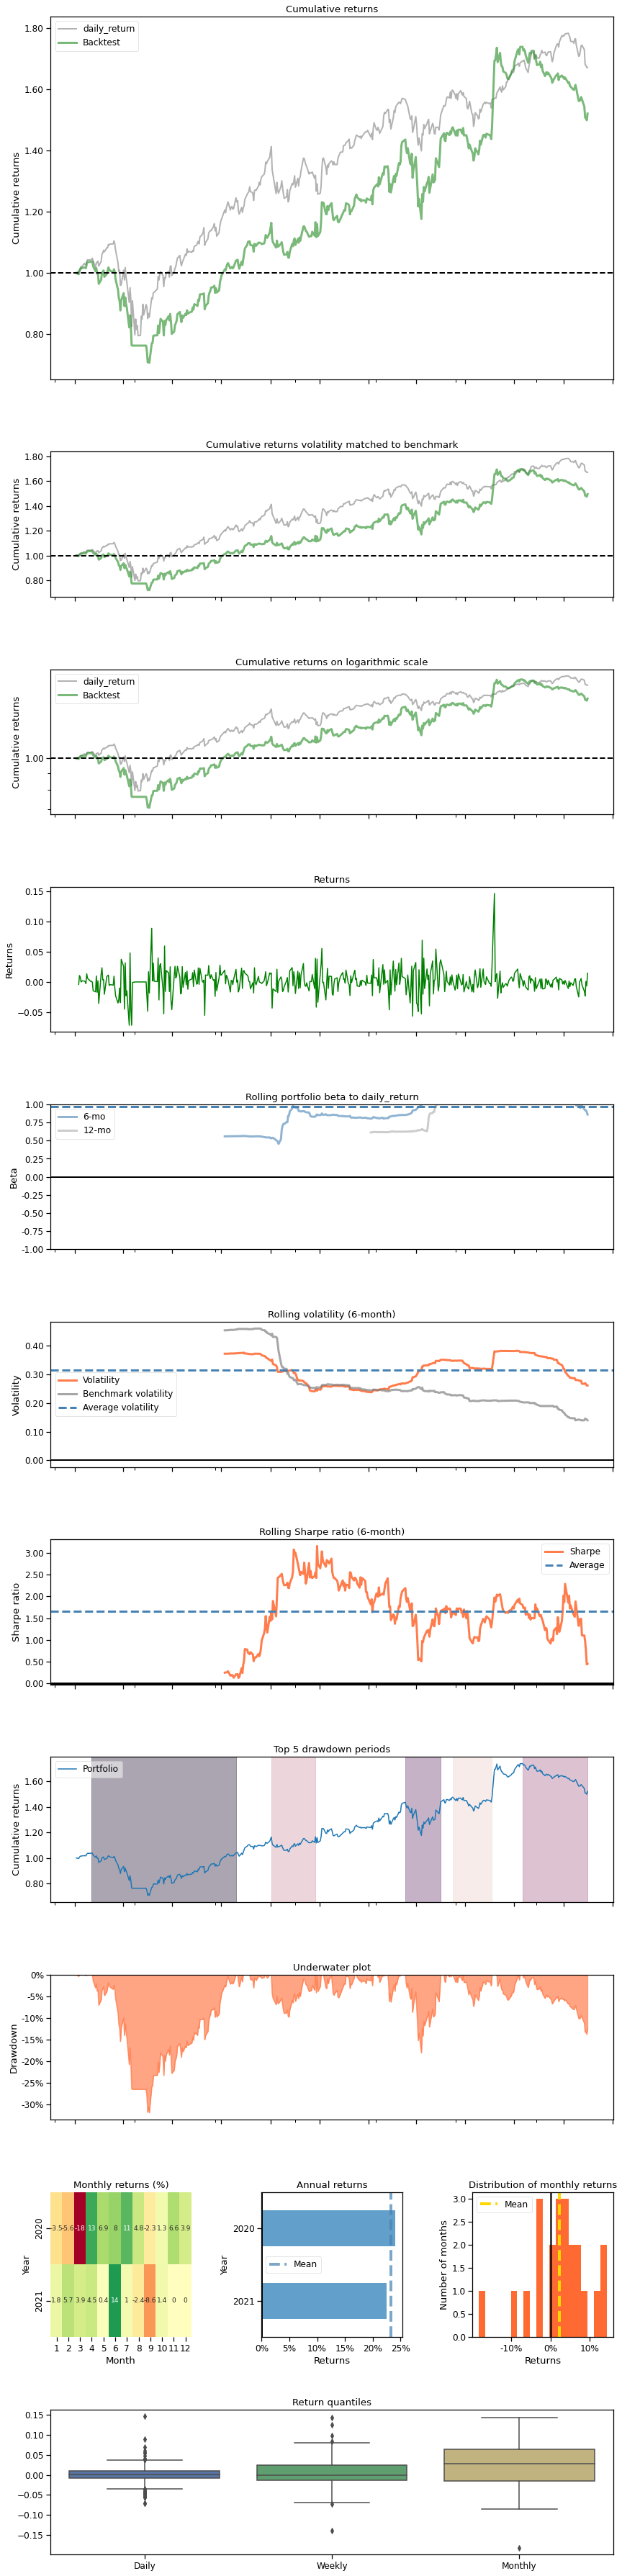

In [ ]:
# Model 6: Ensemble Strategy (Normal Env)
print("==========Compare Ensemble Strategy To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_ensemble, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_ensemble.loc[0,'date'],
              baseline_end = df_account_value_ensemble.loc[len(df_account_value_ensemble)-1,'date'])

==========Compare Minimum Variance Portfolio To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2020-01-02
End date,2021-09-30
Total months,21
,Backtest
Annual return,14.27%
Cumulative returns,26.293%
Annual volatility,22.385%
Sharpe ratio,0.71
Calmar ratio,0.54
Stability,0.82
Max drawdown,-26.564%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.56,2020-02-19,2020-03-23,2020-07-06,99
1,9.74,2020-09-02,2020-10-30,2020-12-16,76
2,7.65,2021-02-09,2021-03-04,2021-04-15,48
3,4.92,2021-09-02,2021-09-30,NaT,NaN
4,3.68,2020-07-20,2020-07-28,2020-08-18,22


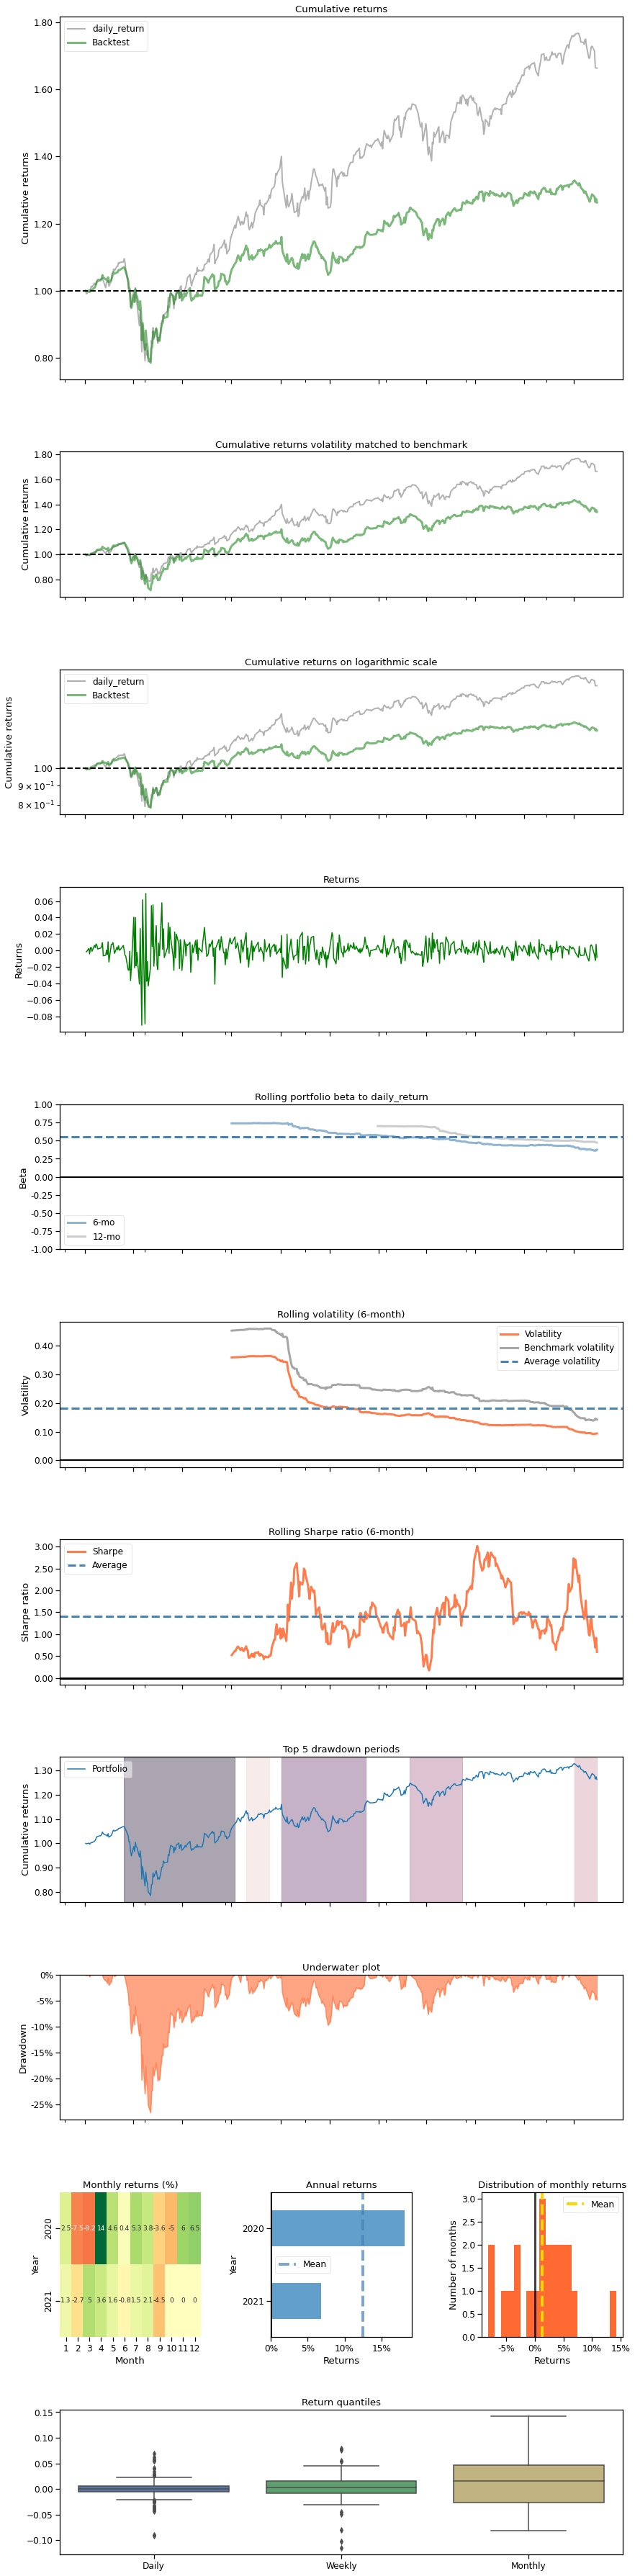

In [ ]:
# Model 7: Minimum Variance Portfolio
print("==========Compare Minimum Variance Portfolio To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_minportfolio, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_minportfolio.loc[0,'date'],
              baseline_end = df_account_value_minportfolio.loc[len(df_account_value_minportfolio)-1,'date'])